1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


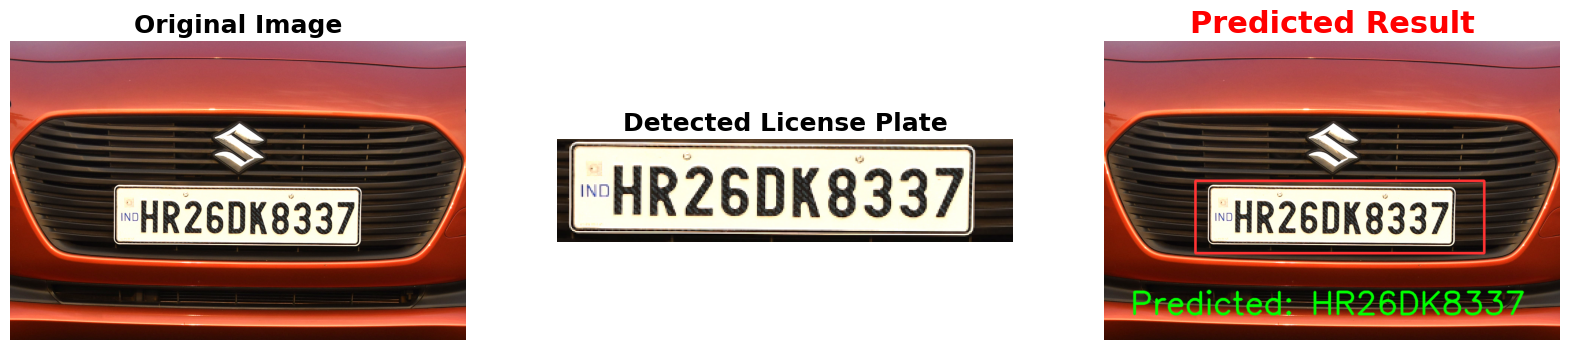

Predicted License Plate Number: HR26DK8337


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('trained_model.h5')

# Load Haar Cascade model for detecting the license plate
haarcascade = cv2.CascadeClassifier('haarcascade_indian_license_plate.xml')

# Load a new image
new_image_path = 'C:\\Users\\dell\\Desktop\\LicensePlateNumber-main\\test_images\\20180402113123_NumberPlate_Swift.jpg'
new_img_input = cv2.imread(new_image_path)
new_img_copy = new_img_input.copy()

# Detect license plate
plate_contour = haarcascade.detectMultiScale(new_img_input, 1.3, 7)
plate_cropped_img = None

for (x, y, w, h) in plate_contour:
    a, b = (int(0.01 * new_img_input.shape[0]), int(0.0125 * new_img_input.shape[1])) 
    plate_cropped_img = new_img_copy[y + a:y + h - a, x + b:x + w - b]
    cv2.rectangle(new_img_copy, (x, y), (x + w, y + h), (51, 51, 255), 3)

# Process the license plate image
plate_cropped_img = cv2.resize(plate_cropped_img, (333, 75))
img_gray = cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img_erode = cv2.erode(img_bin, (3, 3))
img_dilate = cv2.dilate(img_erode, (3, 3))

# Find and filter contours
contours, _ = cv2.findContours(img_dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
LP_WIDTH, LP_HEIGHT = img_dilate.shape[0], img_dilate.shape[1]
dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]

x_contour_list = []
bin_img = []

for contour in contours:
    c_X, c_Y, c_width, c_height = cv2.boundingRect(contour)
    if dimensions[0] < c_width < dimensions[1] and dimensions[2] < c_height < dimensions[3]:
        x_contour_list.append(c_X)
        char_temp = np.zeros((44, 24))
        char = img_dilate[c_Y:c_Y + c_height, c_X:c_X + c_width]
        char = cv2.resize(char, (20, 40))
        char = cv2.subtract(255, char)
        char_temp[2:42, 2:22] = char 
        bin_img.append(char_temp)

# Sorting extracted characters
indices = sorted(range(len(x_contour_list)), key=lambda k: x_contour_list[k])
bin_img = np.array([bin_img[i] for i in indices])

# Character dictionary
dic = {i: c for i, c in enumerate('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}

# Function to fix image dimensions
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

# Predict characters
plate_number = ''
for ch in bin_img:
    img_ = cv2.resize(ch, (28, 28))
    img = fix_dimension(img_)
    img = img.reshape(1, 28, 28, 3) 
    y_ = model.predict(img)[0]  
    index = np.argmax(y_)  
    plate_number += dic[index]

# Overlay predicted text on the image
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(new_img_copy, f"Predicted: {plate_number}", (50, new_img_copy.shape[0] - 50), font, 2, (0, 255, 0), 4, cv2.LINE_AA)

# Display all images in a single figure with increased sizes
plt.figure(figsize=(20, 10))  

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(new_img_input, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=18, fontweight='bold')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Detected License Plate", fontsize=18, fontweight='bold')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(new_img_copy, cv2.COLOR_BGR2RGB))
plt.title("Predicted Result", fontsize=22, fontweight='bold', color='red')  # Increased font size & bold
plt.axis("off")

plt.show()

print("Predicted license plate number:", plate_number)
